## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style for plots
sns.set_theme(style="whitegrid", rc={"axes.facecolor": "#f0f0f0"})

## Load Preprocessed Data

In [3]:
# Load engineered data (from Day 2)
df = pd.read_csv("SMH_Engineered_Data.csv", parse_dates=["Date"], index_col="Date")

# Ensure chronological order
df.sort_index(inplace=True)

# Display first 5 rows
print("Engineered Data:")
display(df.head())

Engineered Data:


,Open,High,Low,Close,Volume,RSI_14,MACD,MACD_Signal,ATR_14,Bollinger_Upper,Bollinger_Middle,Bollinger_Lower,"('VIXCLS', '^VIX')"
Date,,,,,,,,,,,,,
2010-02-22,11.490917,11.495176,11.320555,11.397218,21475000,52.893929,-0.126873,-0.317405,0.280416,11.564284,10.977275,10.390265,19.940001
2010-02-23,11.329072,11.367403,11.043715,11.120378,35881600,45.749613,-0.121403,-0.278205,0.285636,11.567805,10.979191,10.390577,21.370001
2010-02-24,11.184264,11.414253,11.150192,11.316295,30822400,50.812908,-0.100105,-0.242585,0.286225,11.602302,10.995588,10.388875,20.270000
2010-02-25,11.124639,11.312037,11.039458,11.299260,28511200,50.372688,-0.083637,-0.210795,0.285554,11.621146,11.003255,10.385364,20.100000
2010-02-26,11.346107,11.346107,11.150191,11.235372,27008800,48.669622,-0.074878,-0.183612,0.279152,11.644142,11.021143,10.398144,19.500000


## Create Target Variable

In [4]:
# Target = 1 if next day's Close > today's Close, else 0
df["Target"] = (df["Close"].shift(-1) > df["Close"]).astype(int)
df.dropna(subset=["Target"], inplace=True)  # Drop last row with NaN

# Separate features (X) and target (y)
X = df.drop("Target", axis=1)
y = df["Target"]

print("\nClass Distribution:")
print(y.value_counts(normalize=True))


Class Distribution:
1    0.53372
0    0.46628
Name: Target, dtype: float64


## Split Data into Training and Test Sets

In [5]:
# Time-series split (no shuffling)
train_size = int(0.8 * len(X))
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]

print(f"Training set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

Training set size: 3036
Test set size: 760


## Define XGBoost Model and Hyperparameter Grid

In [7]:
# Initialize XGBoost classifier
model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

# Hyperparameter grid for tuning
param_grid = {
    "max_depth": [3, 5],            # Tree depth
    "learning_rate": [0.01, 0.1],    # Step size shrinkage
    "n_estimators": [100, 200],      # Number of trees
    "subsample": [0.8, 1.0],         #% of samples per tree
    "colsample_bytree": [0.8, 1.0]   #% of features per tree
}

## Perform Grid Search with K-Fold Cross-Validation

In [8]:
# K-Fold cross-validation (5 splits, no shuffling)
kfold = KFold(n_splits=5, shuffle=False)

# Grid search for best parameters
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring="accuracy",
    cv=kfold,
    verbose=1,
    n_jobs=-1
)

# Fit to training data
grid_search.fit(X_train, y_train)

# Get best model
best_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")

Fitting 5 folds for each of 32 candidates, totalling 160 fits

Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}


## Evaluate on Test Set


Test Set Metrics:
Accuracy: 0.4763
Classification Report:
               precision    recall  f1-score   support

           0       0.46      0.56      0.51       365
           1       0.50      0.39      0.44       395

    accuracy                           0.48       760
   macro avg       0.48      0.48      0.47       760
weighted avg       0.48      0.48      0.47       760



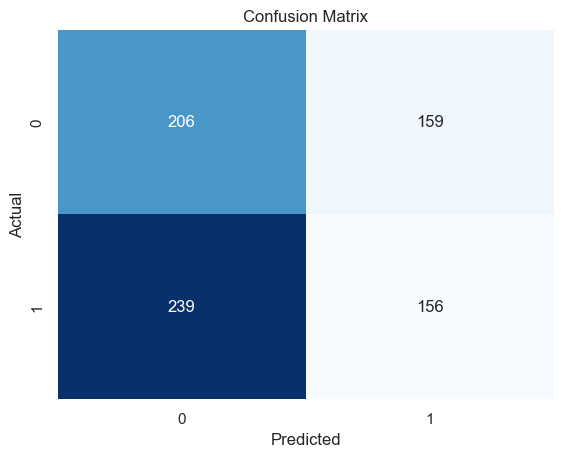

In [9]:
# Predictions
y_pred = best_model.predict(X_test)

# Metrics
print("\nTest Set Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## Feature Importance

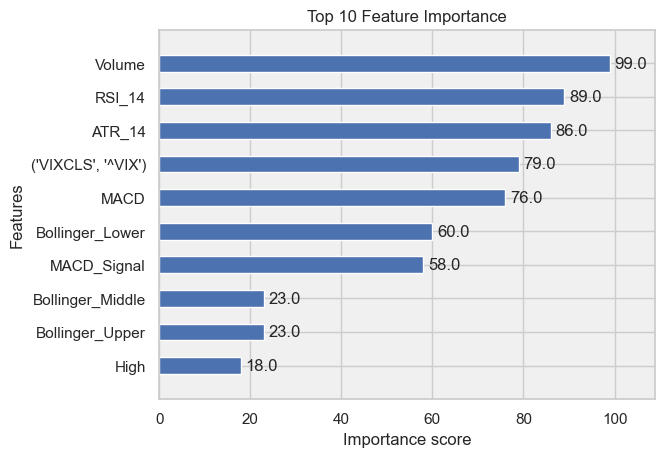

In [10]:
# Plot feature importance
xgb.plot_importance(best_model, max_num_features=10, height=0.5)
plt.title("Top 10 Feature Importance")
plt.show()